In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import yfinance as yf

from datetime import datetime
from matplotlib.pyplot import figure
from pandarallel import pandarallel
from scipy import stats

from invaas.poptions import poptions

pandarallel.initialize(nb_workers=12, progress_bar=True, verbose=2)

%matplotlib widget
# %matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

data_directory = "data/spy-options-data-2020-2022/"

periods = 30
fear_greed_window = 30

raw_data_path = data_directory + "spy_2020_2022.csv"
formatted_data_path = data_directory + f"spy_2020_2022_formatted_{periods}_{fear_greed_window}.csv"
processed_data_path = data_directory + f"spy_2020_2022_processed_{periods}_{fear_greed_window}.csv"

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
refresh_formatted_data = False
refresh_processed_data = False


def get_df_history(product_id):
    df_history = yf.Ticker(product_id).history(interval="1d", period="5y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")
    df_history["close"] = df_history.close.ffill()
    # df_history = df_history.set_index(pd.DatetimeIndex(timestamps))
    df_history.sort_index(ascending=True, inplace=True)

    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        ta=[
            # {"kind": "sma", "length": 10},
            # {"kind": "sma", "length": 20},
            # {"kind": "sma", "length": 50},
            # {"kind": "bbands", "length": 20},
            {"kind": "rsi", "length": 7},
            {"kind": "rsi", "length": 10},
            {"kind": "rsi", "length": 14},
            {"kind": "rsi", "length": 20},
            {"kind": "rsi", "length": 30},
            # {
            #     "kind": "macd",
            #     "fast": 8,
            #     "slow": 21,
            # },
            # {
            #     "kind": "sma",
            #     "close": "volume",
            #     "length": 10,
            #     "prefix": "VOLUME",
            # },
            # {
            #     "kind": "sma",
            #     "close": "volume",
            #     "length": 20,
            #     "prefix": "VOLUME",
            # },
            # {
            #     "kind": "sma",
            #     "close": "volume",
            #     "length": 50,
            #     "prefix": "VOLUME",
            # },
        ],
    )
    df_history.ta.strategy(CustomStrategy)
    df_history.sort_index(ascending=True, inplace=True)

    return df_history


if not refresh_processed_data and os.path.isfile(processed_data_path):
    df_options = pd.read_csv(processed_data_path, low_memory=False)
else:
    if not refresh_formatted_data and os.path.isfile(formatted_data_path):
        df_formatted = pd.read_csv(formatted_data_path, low_memory=False)
    else:
        df_formatted = pd.read_csv(raw_data_path, low_memory=False)

        columns = df_formatted.columns
        columns = [s.replace("[", "") for s in columns]
        columns = [s.replace("]", "") for s in columns]
        columns = [s.replace(" ", "") for s in columns]
        df_formatted.columns = columns

        date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
        numeric_cols = df_formatted.columns.to_list()
        numeric_cols.remove("QUOTE_READTIME")
        numeric_cols.remove("QUOTE_DATE")
        numeric_cols.remove("EXPIRE_DATE")

        df_formatted.drop(columns=date_columns, inplace=True)

        for i in numeric_cols:
            df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

        df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
        df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
        df_formatted["OPTION_ID"] = (
            df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)
        ).apply(lambda x: hash(x))
        df_formatted_total_options = (
            df_formatted.groupby("OPTION_ID", as_index=False).size().rename(columns={"size": "total"})
        )
        df_formatted = df_formatted.loc[
            df_formatted.OPTION_ID.isin(
                df_formatted_total_options.loc[df_formatted_total_options.total > periods].OPTION_ID
            )
        ]
        df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
            lambda x: pd.Timestamp(x).round(freq="D")
        )
        df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)
        df_formatted.reset_index(drop=True, inplace=True)

        def get_df_rolling_ask(df_formatted_group_by_option, column, ask_type):
            f_type = np.argmax if ask_type == "MAX" else np.argmin

            def rolling_f_type(series, f):
                # fist compute the index in the sliding window
                ids = series.rolling(periods).apply(f)
                # 0 <= ids <= n-1

                # how many rows have past from the sliding window maximum?
                ids = periods - 1 - ids
                # 0 <= ids <= n-1

                # subtract `ids` from the actual positions
                ids = np.arange(len(series)) - ids
                # 0 <= ids <= len(series)-1

                # convert the positions stored in `ids` with the corrisponding dates (series.index)
                ids.loc[~ids.isna()] = series.index[ids.dropna().astype(int)]
                ids = ids.shift(periods - periods)

                return ids

            df_rolling_ask = pd.DataFrame(df_formatted_group_by_option.apply(rolling_f_type, f_type)).reset_index()
            df_rolling_ask[column] = df_rolling_ask.groupby("level_0", as_index=False)[column].shift(periods=-periods)
            max_column_name = f"{ask_type}_{column}_{periods}"
            max_column_rename = {}
            max_column_rename[column] = f"{max_column_name}_INDEX"
            df_rolling_ask = df_rolling_ask.drop(columns="level_0").rename(columns=max_column_rename)
            df_rolling_ask.set_index(keys="level_1", inplace=True)
            max_column_rename[column] = max_column_name
            return df_rolling_ask.merge(
                df_formatted.rename(columns=max_column_rename)[[max_column_rename[column]]],
                left_on=(f"{max_column_name}_INDEX"),
                right_index=True,
                how="inner",
            )

        for column in ["C_ASK", "P_ASK"]:
            df_formatted_group_by_option = df_formatted.groupby("OPTION_ID", as_index=False)[column]
            df_rolling_max_ask = get_df_rolling_ask(
                df_formatted_group_by_option=df_formatted_group_by_option,
                column=column,
                ask_type="MAX",
            )
            df_rolling_min_ask = get_df_rolling_ask(
                df_formatted_group_by_option=df_formatted_group_by_option,
                column=column,
                ask_type="MIN",
            )
            df_formatted = df_formatted.join(df_rolling_max_ask)
            df_formatted = df_formatted.join(df_rolling_min_ask)

        with open("data/cnn_fear_greed_index_data.json") as f:
            cnn_fear_greed_index_data = json.load(f)

        df_fear_greed_index = pd.DataFrame(
            data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
        )
        df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
        timestamps = [pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]
        timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
        df_fear_greed_index["QUOTE_UNIXTIME"] = pd.DatetimeIndex(timestamps)
        df_fear_greed_index.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")
        df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.ffill()
        df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.astype(float).round().shift()
        df_fear_greed_index[f"fear_greed_index_max_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).max()
        df_fear_greed_index[f"fear_greed_index_min_{fear_greed_window}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=fear_greed_window, min_periods=fear_greed_window
        ).min()
        df_fear_greed_index.sort_values(by="QUOTE_UNIXTIME", ascending=True, inplace=True)
        df_fear_greed_index.dropna(subset="fear_greed_index", inplace=True)
        df_fear_greed_index["fear_greed_index_slope"] = (
            df_fear_greed_index["fear_greed_index"]
            .rolling(window=fear_greed_window)
            .apply(lambda s: stats.linregress(x=s.reset_index().index, y=s)[0])
        )
        df_fear_greed_index["fear_greed_index_slope_slope"] = (
            df_fear_greed_index["fear_greed_index_slope"]
            .rolling(window=fear_greed_window)
            .apply(lambda s: stats.linregress(x=s.reset_index().index, y=s)[0])
        )
        df_formatted = df_formatted.merge(
            df_fear_greed_index[
                [
                    "QUOTE_UNIXTIME",
                    "fear_greed_index",
                    "fear_greed_index_slope",
                    "fear_greed_index_slope_slope",
                    f"fear_greed_index_max_{fear_greed_window}",
                    f"fear_greed_index_min_{fear_greed_window}",
                ]
            ],
            on="QUOTE_UNIXTIME",
            how="left",
        )

        df_history = get_df_history("SPY")  # TODO: change this if not spy
        df_history[f"RSI_{periods}_slope"] = (
            df_history[f"RSI_{periods}"]
            .rolling(window=periods)
            .apply(lambda s: stats.linregress(x=s.reset_index().index, y=s)[0])
        )
        df_history[f"RSI_{periods}_slope_slope"] = (
            df_history[f"RSI_{periods}_slope"]
            .rolling(window=periods)
            .apply(lambda s: stats.linregress(x=s.reset_index().index, y=s)[0])
        )
        df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME)
        df_formatted = df_formatted.merge(df_history, left_on="QUOTE_UNIXTIME", right_index=True, how="inner")

        df_formatted.to_csv(formatted_data_path, index=False)

    def get_options_data(row):
        return [
            {
                "option_id": hash("call" + str(row.OPTION_ID)),
                "option_type": "call",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.C_DELTA,
                "gamma": row.C_GAMMA,
                "vega": row.C_VEGA,
                "theta": row.C_THETA,
                "rho": row.C_RHO,
                "iv": row.C_IV,
                "volume": row.C_VOLUME,
                "last": row.C_LAST,
                "bid": row.C_BID,
                "ask": row.C_ASK,
                "max_ask": row[f"MAX_C_ASK_{periods}"],
                "max_ask_index": row[f"MAX_C_ASK_{periods}_INDEX"],
                "min_ask": row[f"MIN_C_ASK_{periods}"],
                "min_ask_index": row[f"MIN_C_ASK_{periods}_INDEX"],
                "rsi": row[f"RSI_{periods}"],
                "rsi_slope": row[f"RSI_{periods}_slope"],
                "rsi_slope_slope": row[f"RSI_{periods}_slope_slope"],
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_slope": row.fear_greed_index_slope,
                "fear_greed_index_slope_slope": row.fear_greed_index_slope_slope,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
            {
                "option_id": hash("put" + str(row.OPTION_ID)),
                "option_type": "put",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.P_DELTA,
                "gamma": row.P_GAMMA,
                "vega": row.P_VEGA,
                "theta": row.P_THETA,
                "rho": row.P_RHO,
                "iv": row.P_IV,
                "volume": row.P_VOLUME,
                "last": row.P_LAST,
                "bid": row.P_BID,
                "ask": row.P_ASK,
                "max_ask": row[f"MAX_P_ASK_{periods}"],
                "max_ask_index": row[f"MAX_P_ASK_{periods}_INDEX"],
                "min_ask": row[f"MIN_P_ASK_{periods}"],
                "min_ask_index": row[f"MIN_P_ASK_{periods}_INDEX"],
                "rsi": row[f"RSI_{periods}"],
                "rsi_slope": row[f"RSI_{periods}_slope"],
                "rsi_slope_slope": row[f"RSI_{periods}_slope_slope"],
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_slope": row.fear_greed_index_slope,
                "fear_greed_index_slope_slope": row.fear_greed_index_slope_slope,
                "fear_greed_index_max": row[f"fear_greed_index_max_{fear_greed_window}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{fear_greed_window}"],
            },
        ]

    def flatten(xss):
        return [x for xs in xss for x in xs]

    options_data = flatten(df_formatted[: len(df_formatted)].parallel_apply(get_options_data, axis=1))
    df_options = pd.DataFrame(data=options_data)
    df_options.to_csv(processed_data_path, index=False)

df_options["max_ask_pct"] = (df_options.max_ask - df_options.ask) / df_options.ask
df_options["min_ask_pct"] = (df_options.min_ask - df_options.ask) / df_options.ask
df_options["max_before_min"] = df_options.max_ask_index < df_options.min_ask_index
df_options["in_the_money"] = ((df_options.option_type == "call") & (df_options.strike < df_options.underlying_last)) | (
    (df_options.option_type == "put") & (df_options.strike > df_options.underlying_last)
)

df_options

,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,max_ask_index,min_ask,min_ask_index,rsi,rsi_slope,rsi_slope_slope,fear_greed_index,fear_greed_index_slope,fear_greed_index_slope_slope,fear_greed_index_max,fear_greed_index_min,max_ask_pct,min_ask_pct,max_before_min,in_the_money
0,6018450966662199065,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,270.0,54.9,0.169,0.96247,0.00230,0.09124,-0.03148,0.31026,0.30852,10.0,53.85,55.31,55.51,67.91,83640.0,52.30,53202.0,68.894816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223383,-0.057827,False,True
1,2703641299143580011,put,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,270.0,54.9,0.169,-0.01684,0.00147,0.04655,-0.01293,-0.00678,0.25518,NaN,0.00,0.17,0.17,0.23,2414.0,0.01,71215.0,68.894816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352941,-0.941176,True,False
2,7920065068013499351,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,275.0,49.9,0.154,0.95833,0.00278,0.10050,-0.03230,0.31394,0.28566,NaN,0.00,50.34,50.53,62.89,83641.0,47.75,53203.0,68.894816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.244607,-0.055017,False,True
3,-7745255013793634946,put,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,275.0,49.9,0.154,-0.02157,0.00193,0.05840,-0.01595,-0.00872,0.24238,1.0,0.28,0.21,0.23,0.30,2415.0,0.01,71216.0,68.894816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304348,-0.956522,True,False
4,-2660387845786641280,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,280.0,44.9,0.138,0.94983,0.00341,0.11693,-0.03563,0.31725,0.26822,NaN,0.00,45.41,45.66,57.90,83642.0,42.79,53204.0,68.894816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268068,-0.062856,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183441,3673666653860688362,put,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,590.0,207.6,0.543,-0.87442,0.00305,0.81016,-0.00808,-1.71905,0.29992,0.0,193.26,205.00,212.60,NaN,NaN,NaN,NaN,47.061011,-0.421235,-0.029386,37.0,-1.262514,-0.058528,76.0,36.0,NaN,NaN,False,True
5183442,-5046196289727548837,call,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,595.0,212.6,0.556,0.08891,0.00157,0.88126,-0.01276,0.62712,0.18258,0.0,6.80,2.00,5.50,NaN,NaN,NaN,NaN,47.061011,-0.421235,-0.029386,37.0,-1.262514,-0.058528,76.0,36.0,NaN,NaN,False,False
5183443,6600196568020677094,put,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,595.0,212.6,0.556,-0.86806,0.00287,0.84727,-0.00847,-1.81885,0.30789,NaN,0.00,210.50,217.50,NaN,NaN,NaN,NaN,47.061011,-0.421235,-0.029386,37.0,-1.262514,-0.058528,76.0,36.0,NaN,NaN,False,True
5183444,-4489161560384381440,call,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,600.0,217.6,0.569,0.07545,0.00142,0.77750,-0.01128,0.53365,0.17619,12.0,2.55,2.50,3.45,NaN,NaN,NaN,NaN,47.061011,-0.421235,-0.029386,37.0,-1.262514,-0.058528,76.0,36.0,NaN,NaN,False,False


In [3]:
print(len(df_options))
print(len(df_options.loc[df_options.max_ask.isnull()]))
print(len(df_options.loc[df_options.min_ask.isnull()]))
df_options.describe(include="all").astype(str)

5183446
1316826
1316826


/home/vscode/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/vscode/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,max_ask_index,min_ask,min_ask_index,rsi,rsi_slope,rsi_slope_slope,fear_greed_index,fear_greed_index_slope,fear_greed_index_slope_slope,fear_greed_index_max,fear_greed_index_min,max_ask_pct,min_ask_pct,max_before_min,in_the_money
count,5183446.0,5183446,5183446,5183446,5183446.0,5183446.0,5183446.0,5183446.0,5183446.0,5183304.0,5183304.0,5183304.0,5183304.0,5183304.0,4995065.0,4329775.0,5182658.0,5182658.0,5182658.0,3866620.0,3866620.0,3866620.0,3866620.0,5183446.0,5088812.0,4966342.0,2379528.0,2199518.0,2022938.0,2199518.0,2199518.0,3866172.0,3865542.0,5183446,5183446
unique,nan,2,758,164,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,2
top,nan,call,2021-11-06 00:00:00+00:00,2021-12-17 21:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,False
freq,nan,2591723,8224,222132,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2960066,2591848
mean,1.450081250672666e+16,nan,nan,nan,208.44489484408626,386.81048857073125,366.2309153022912,79.84188649790116,0.20786633641017963,0.061377349813941044,-7.16732997335483,-4.273652451353425,-0.05487317240316212,-0.17676348886926183,0.325085603106266,189.24003302712035,29.880180199040723,46.262370376358945,47.367116543287295,61.24637173034845,1281122.3400132416,43.0691533509887,1293594.5726942394,54.20971368742224,-0.01824040844773535,0.0003354995616229046,39.16426030708611,0.0517900191867398,0.002998663046786983,57.8417171398461,19.019125099226287,inf,inf,nan,nan
std,5.336108723942362e+18,nan,nan,nan,214.28945070866197,55.93111870637418,117.85477394158923,74.10176115308039,0.18785161249208368,0.6097005475830474,8263.766206348793,68.27349741470688,0.2449836036545431,5.614262441778176,0.38684982574298166,2345.348596510615,48.49748971584839,62.023225396788206,62.76557232391271,69.9862631177818,722841.6097826993,60.39970499483828,724689.804763579,9.279971629036108,0.4274596406434609,0.02884353843104512,16.715752079266753,1.059318308005822,0.08349046901989329,11.921238466167331,10.620170391049161,nan,nan,nan,nan
min,-9.222907890833574e+18,nan,nan,nan,0.0,222.21,5.0,0.0,0.0,-1.0,-14950363.96601,-2815.39969,-45.23137,-2878.27141,-0.0005,0.0,0.0,0.0,0.0,0.01,2414.0,0.0,2494.0,25.498952768069195,-1.452397787354171,-0.0651911706336578,3.0,-1.956840934371524,-0.1961160156941156,30.0,3.0,-0.9939939939939939,-1.0,nan,nan
25%,-4.600668279271921e+18,nan,nan,nan,45.0,342.52,291.0,25.2,0.066,-0.34575,0.00073,0.12985,-0.06511,-0.33982,0.18796,0.0,0.25,3.03,3.41,8.73,661135.0,2.36,663273.75,47.92180113787415,-0.2968799658024193,-0.0197388043655513,27.0,-0.7733036707452723,-0.0629639409008402,48.0,13.0,0.062444510210121325,-0.5256410256410257,nan,nan
50%,-1.655815262595997e+16,nan,nan,nan,140.0,393.48,365.0,58.5,0.155,0.0,0.0029,0.42276,-0.03984,0.0,0.25137,2.0,8.9,20.37,21.31,34.95,1275442.0,16.28,1282942.5,55.39462183877711,0.0552819281134193,0.0015640567634373,37.0,-0.0146829810901,0.0112139430661431,58.0,17.0,0.20242914979757085,-0.25795053003533563,nan,nan
75%,4.672343878109479e+18,nan,nan,nan,290.0,434.01,440.0,115.4,0.303,0.65371,0.00578,0.87945,-0.01762,0.2984,0.34917,22.0,37.32,64.72,66.5,90.53,1885788.0,59.44,1909123.0,61.08582019132162,0.2827972308577964,0.0183855612806215,53.0,0.8066740823136817,0.0604403607518426,68.0,22.0,0.48499702167081105,-0.09002218455336017,nan,nan


<Axes: xlabel='quote_unixtime'>

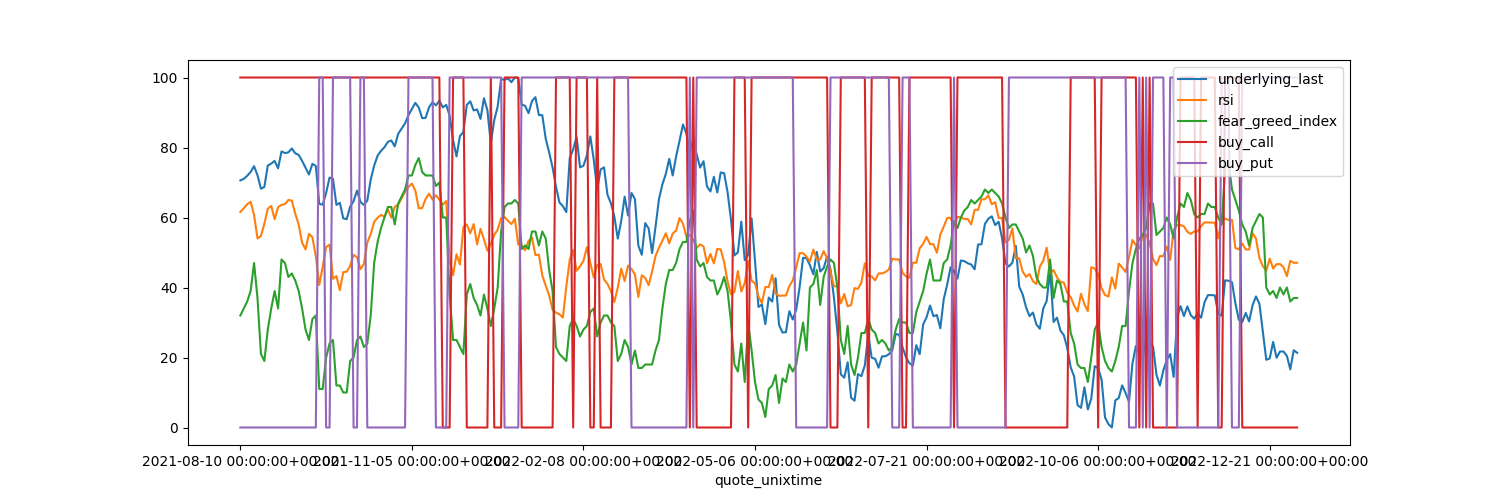

In [15]:
plot_columns = [
    "underlying_last",
    "rsi",
    "rsi_slope",
    "rsi_slope_slope",
    "fear_greed_index",
    "fear_greed_index_slope",
    "fear_greed_index_slope_slope",
    # "fear_greed_index_min",
    "fear_greed_index_max",
]
df_plot = df_options[["quote_unixtime"] + plot_columns].dropna().drop_duplicates()
df_plot["underlying_last"] = (
    (df_plot.underlying_last - df_plot.underlying_last.min())
    / (df_plot.underlying_last.max() - df_plot.underlying_last.min())
    * 100
)

min_fear_greed_index_threshold = 30
max_fear_greed_index_threshold = 70

# def get_slope_grade(x):
#     if x < 0:
#         return 0
#     elif x > 0:
#         return 100
#     else:
#         return None


# df_plot["fear_greed_index_slope_grade"] = df_plot.fear_greed_index_slope.apply(lambda x: get_slope_grade(x))
# df_plot["fear_greed_index_slope_slope_grade"] = df_plot.fear_greed_index_slope_slope.apply(lambda x: get_slope_grade(x))
# df_plot.plot(x="quote_unixtime", y=plot_columns + ["fear_greed_index_slope_grade", "fear_greed_index_slope_slope_grade"], figsize=(15, 5))


def get_buy_call(row):
    # if row["rsi_slope_slope"] > 0:
    #     return 100

    # if row["rsi"] < min_fear_greed_index_threshold or row["fear_greed_index"] < min_fear_greed_index_threshold:
    #     return 100

    if (
        row["fear_greed_index"] < min_fear_greed_index_threshold
        or row["rsi"] < min_fear_greed_index_threshold
        or (
            row["fear_greed_index"] >= min_fear_greed_index_threshold
            and row["rsi"] >= min_fear_greed_index_threshold
            # and row["rsi_slope"] > 0.05
            and (row["rsi"] > row["fear_greed_index_max"] or (row["rsi"] > 50 and row["fear_greed_index"] > 60))
        )
    ):
        return 100

    return 0


def get_buy_put(row):
    # if row["rsi"] > max_fear_greed_index_threshold or row["fear_greed_index"] > max_fear_greed_index_threshold:
    #     return 100

    if (
        row["fear_greed_index"] > max_fear_greed_index_threshold
        or row["rsi"] > max_fear_greed_index_threshold
        or (
            row["fear_greed_index"] <= max_fear_greed_index_threshold
            and row["rsi"] <= max_fear_greed_index_threshold
            # and row["rsi_slope"] < -0.05
            and (row["rsi"] < row["fear_greed_index_max"] and (row["rsi"] < 50 or row["fear_greed_index"] < 60))
        )
    ):
        return 100

    return 0


df_plot["buy_call"] = df_plot.apply(lambda row: get_buy_call(row), axis=1)
df_plot["buy_put"] = df_plot.apply(lambda row: get_buy_put(row), axis=1)

df_plot.plot(
    x="quote_unixtime",
    y=[
        "underlying_last",
        "rsi",
        # "rsi_slope",
        # "rsi_slope_slope",
        "fear_greed_index",
        "buy_call",
        "buy_put",
    ],
    figsize=(15, 5),
)

In [ ]:
min_dte = periods
max_dte = periods * 2
# max_dte = 30
max_ask = 1000
min_ask = 0.1
min_volume = 100
# max_strike_distance_pct = 0.1
min_strike_distance_pct = 0.05
target_profit = 1.1

df_options["should_buy"] = (
    (df_options.max_ask > (df_options.ask * target_profit))
    & (df_options.min_ask < (df_options.ask * (2 - target_profit)))
    & df_options.max_before_min
)
df_options_filtered = df_options.loc[
    (df_options.fear_greed_index_max.notnull())
    & (~df_options.in_the_money)
    & (df_options.bid > 0)
    & (df_options.ask > 0)
    & (df_options.ask < max_ask)
    & (df_options.ask > min_ask)
    & (df_options.volume > min_volume)
    # & (df_options.strike_distance_pct < max_strike_distance_pct)
    & (df_options.strike_distance_pct > min_strike_distance_pct)
    & (df_options.days_to_expire > min_dte)
    & (df_options.days_to_expire < max_dte)
]

min_fear_greed_index_threshold = 30
max_fear_greed_index_threshold = 70
max_diff = 0

df_options_filtered["did_buy"] = (
    (df_options_filtered.option_type == "call")
    & (
        # (df_options_filtered.rsi_slope > 0)
        # & (df_options_filtered.fear_greed_index < min_fear_greed_index_threshold)
        (df_options_filtered.fear_greed_index < min_fear_greed_index_threshold)
        | (df_options_filtered.rsi < min_fear_greed_index_threshold)
        | (
            (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
            & (df_options_filtered.rsi >= min_fear_greed_index_threshold)
            & (
                ((df_options_filtered.rsi > df_options_filtered.fear_greed_index_max))
                | ((df_options_filtered.rsi > 50) & (df_options_filtered.fear_greed_index > 60))
            )
        )
        # | (
        #     (df_options_filtered.fear_greed_index > 60)
        #     (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
        # (df_options_filtered.rsi <= min_fear_greed_index_threshold)
        # | (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
        #     (
        # | (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
        # | (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min + max_diff))
        #     )
        # )
    )
) | (
    (df_options_filtered.option_type == "put")
    & (
        # (df_options_filtered.rsi_slope < 0)
        # & (df_options_filtered.fear_greed_index > min_fear_greed_index_threshold)
        (df_options_filtered.fear_greed_index > max_fear_greed_index_threshold)
        | (df_options_filtered.rsi > max_fear_greed_index_threshold)
        | (
            (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
            & (df_options_filtered.rsi <= max_fear_greed_index_threshold)
            & (
                ((df_options_filtered.rsi < df_options_filtered.fear_greed_index_max))
                & ((df_options_filtered.rsi < 50) | (df_options_filtered.fear_greed_index < 60))
            )
        )
        # | (
        # (df_options_filtered.rsi >= max_fear_greed_index_threshold)
        # | (df_options_filtered.fear_greed_index >= min_fear_greed_index_threshold)
        #     & (df_options_filtered.fear_greed_index < 40)
        #     & (df_options_filtered.fear_greed_index <= max_fear_greed_index_threshold)
        #     (
        # | (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
        # | (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min + max_diff))
        #     )
        # )
    )
)

df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)

# df_options_filtered["did_buy"] = (
#     (df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_min)
# ) | ((df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_max))
# df_options_filtered["should_buy"] = df_options_filtered.max_ask >= (df_options_filtered.ask * 0.5)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask_pct_diff > 0

total_gains = (
    df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask
    * (target_profit - 1)
    * 100
).sum()
# total_gains = (df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask * (0.5) * 100).sum()

# max_loss = -1
max_loss = -1 if (1 - target_profit) < -1 else (1 - target_profit)
total_losses = (
    df_options_filtered.loc[df_options_filtered.did_buy & ~df_options_filtered.should_buy].ask * max_loss * 100
).sum()
print(f"Total gains: ${total_gains:.2f}")
print(f"Total losses: ${total_losses:.2f}")
print(f"Total profit: ${total_gains + total_losses:.2f}")
df_options_filtered_grouped_size = df_options_filtered.groupby(["did_buy", "should_buy"], as_index=False).size()
# df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

did_buy_and_should_buy = df_options_filtered_grouped_size.loc[
    df_options_filtered_grouped_size.did_buy & df_options_filtered_grouped_size.should_buy
].iloc[0]["size"]
did_buy_and_should_not_buy = df_options_filtered_grouped_size.loc[
    df_options_filtered_grouped_size.did_buy & ~df_options_filtered_grouped_size.should_buy
].iloc[0]["size"]
print(f"Accuracy: {did_buy_and_should_buy/(did_buy_and_should_buy+did_buy_and_should_not_buy)*100:.2f}%")

df_options_filtered_grouped_size

Total gains: $136988.40
Total losses: $-88780.50
Total profit: $48207.90
Accuracy: 62.45%


/tmp/ipykernel_6713/2679804041.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["did_buy"] = (
/tmp/ipykernel_6713/2679804041.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)


,did_buy,should_buy,size
0,False,False,3195
1,False,True,3298
2,True,False,3108
3,True,True,5169


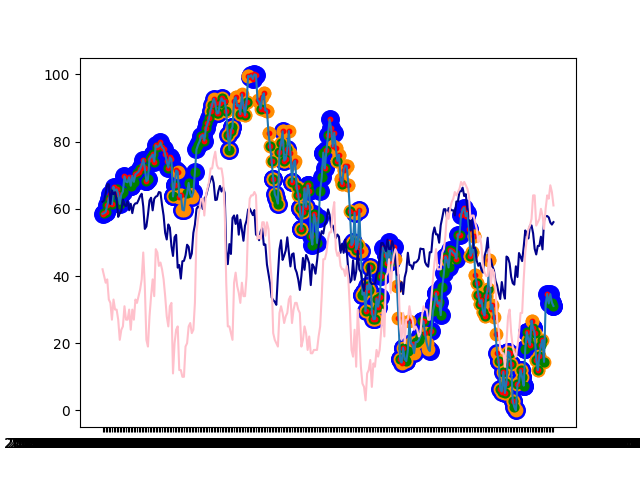

In [62]:
plot_columns = ["underlying_last", "rsi", "fear_greed_index", "option_type", "did_buy", "should_buy"]
df_plot = df_options_filtered[["quote_unixtime"] + plot_columns].dropna().drop_duplicates()
df_plot["underlying_last"] = (
    (df_plot.underlying_last - df_plot.underlying_last.min())
    / (df_plot.underlying_last.max() - df_plot.underlying_last.min())
    * 100
)

fig = plt.figure()

plt.plot(df_plot.quote_unixtime, df_plot.underlying_last)
plt.plot(df_plot.quote_unixtime, df_plot.rsi, c="darkblue")
plt.plot(df_plot.quote_unixtime, df_plot.fear_greed_index, c="pink")

plt.scatter(
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "call")].quote_unixtime,
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "call")].underlying_last,
    s=160,
    c="blue",
)
plt.scatter(
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "put")].quote_unixtime,
    df_plot.loc[df_plot.did_buy & (df_plot.option_type == "put")].underlying_last,
    s=80,
    c="darkorange",
)
plt.scatter(
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "call")].quote_unixtime,
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "call")].underlying_last,
    s=40,
    c="green",
)
plt.scatter(
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "put")].quote_unixtime,
    df_plot.loc[df_plot.should_buy & (df_plot.option_type == "put")].underlying_last,
    s=10,
    c="red",
)

plt.show()

In [63]:
# print(
#     len(df_options_filtered.loc[(df_options_filtered.in_the_money) & (df_options_filtered.max_before_min)])
#     / len(df_options_filtered.loc[df_options_filtered.in_the_money])
# )
# print(
#     len(df_options_filtered.loc[(df_options_filtered.in_the_money) & (df_options_filtered.should_buy)])
#     / len(df_options_filtered.loc[df_options_filtered.in_the_money])
# )

# print()

print(
    len(df_options_filtered.loc[(~df_options_filtered.in_the_money) & (df_options_filtered.max_before_min)])
    / len(df_options_filtered.loc[~df_options_filtered.in_the_money])
)
print(
    len(df_options_filtered.loc[(~df_options_filtered.in_the_money) & (df_options_filtered.should_buy)])
    / len(df_options_filtered.loc[~df_options_filtered.in_the_money])
)

# df_options_filtered.loc[~df_options_filtered.in_the_money].describe(include="all").astype(str)
# df_options_filtered.loc[(~df_options_filtered.in_the_money) & (df_options_filtered.max_before_min)].describe(include="all").astype(str)
df_options_filtered.loc[(~df_options_filtered.in_the_money) & (df_options_filtered.should_buy)].describe(
    include="all"
).astype(str)

0.8787406905890318
0.5732566012186865


,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,max_ask_index,min_ask,min_ask_index,rsi,rsi_slope,rsi_slope_slope,fear_greed_index,fear_greed_index_slope,fear_greed_index_slope_slope,fear_greed_index_max,fear_greed_index_min,max_ask_pct,min_ask_pct,max_before_min,in_the_money,should_buy,did_buy
count,8467.0,8467,8467,8467,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,8467.0,7969.0,8467.0,8467.0,8467.0,8467.0,8467,8467,8467,8467
unique,nan,2,272,64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,1,1,2
top,nan,put,2021-11-05 00:00:00+00:00,2022-04-14 20:00:00+00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,False,True,True
freq,nan,6300,127,658,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8467,8467,8467,5169
mean,4909338541171946.0,nan,nan,nan,49.868071335774175,430.2787303649463,390.44413605763555,58.899846462737685,0.13613003425062006,-0.05084677926065903,0.00462999409472068,0.2787896397779615,-0.07181918507145388,-0.034509050431085396,0.28464451517656786,879.5835597023739,2.4592122357387507,2.428792960907051,2.4522522735325376,4.873151057044998,1956095.436045825,0.24310617692216843,2017056.5660800757,51.12951433395647,-0.0038796574514834365,0.004804967949952424,39.920987362702256,0.03663869136382781,-0.0003235419677776466,59.43096728475257,18.032479036258415,1.034888366675699,-0.9138829026982274,nan,nan,nan,nan
std,5.392976826693255e+18,nan,nan,nan,5.205419117480037,31.1143297077824,54.89238669630374,38.802615391661625,0.08676563238098509,0.12575105375527126,0.002870232992641258,0.14528053831009288,0.03774560898575838,0.07497179428800375,0.10532495431699129,2074.8456425822014,1.9508652924474843,1.9296388406349738,1.9411200267682527,4.407308701389702,331688.46301557083,0.5077992365846878,325173.47298771614,9.626856738269753,0.4858597724748881,0.03377060127347677,17.065278638340796,1.1133454223136496,0.0846831322715573,10.89386982486733,7.947278351691922,1.031935189061013,0.11996201213556851,nan,nan,nan,nan
min,-9.221057072434818e+18,nan,nan,nan,41.96,357.76,180.0,18.4,0.051,-0.3096,0.0,0.01133,-0.1921,-0.22794,0.09238,101.0,0.07,0.09,0.11,0.13,1319614.0,0.01,1392725.0,31.42083148837202,-1.0350348643822218,-0.065190822183582,3.0,-1.956840934371524,-0.1961160156941156,30.0,3.0,0.10037174721189591,-0.9988425925925927,nan,nan,nan,nan
25%,-4.690442957075841e+18,nan,nan,nan,45.0,405.2,357.0,32.4,0.076,-0.141795,0.0022,0.156925,-0.09723,-0.088255,0.213845,171.0,0.88,0.86,0.87,1.53,1714151.0,0.01,1767892.0,43.725205125891954,-0.4236268661115022,-0.0225270878838606,26.0,-0.8482758620689655,-0.0681327046118478,48.0,13.0,0.3209876543209876,-0.9838997695852535,nan,nan,nan,nan
50%,-4.169386246880048e+16,nan,nan,nan,50.0,437.79,396.0,46.2,0.108,-0.06127,0.00449,0.28446,-0.07145,-0.03817,0.27337,308.0,2.02,2.0,2.02,3.64,1937647.0,0.05,1990933.0,50.64372109846198,0.0395150679129529,0.0100337505493395,38.0,-0.0994438264738598,0.0046263243920757,62.0,19.0,0.7000000000000001,-0.96,nan,nan,nan,nan
75%,4.631187245883671e+18,nan,nan,nan,53.0,455.48,425.0,70.3,0.163,0.015105,0.00688,0.39917,-0.041830000000000006,0.008515,0.33008499999999996,697.5,3.54,3.51,3.54,6.85,2257338.5,0.21,2325989.5,59.80420179655143,0.40691212760801,0.0334038328145243,55.0,0.7999999999999998,0.0562895616313268,66.0,20.0,1.3464810748446165,-0.9053497942386831,nan,nan,nan,nan


In [52]:
money = 10000
start_money = money
contract_fee = 0.04
total_contracts = 1
# max_buy_amount = 5
max_buy_pct = 0.2
# max_owned_option_type = 100
min_gain_pct = target_profit - 1
max_loss_pct = -1 if (1 - target_profit) < -1 else (1 - target_profit)
# max_loss_pct = -0.1

first_quote_datetime = pd.to_datetime(
    df_options.loc[df_options.fear_greed_index_max.notnull()].quote_unixtime.values[0]
)

df_options_simulate = df_options.loc[
    (pd.to_datetime(df_options.quote_unixtime) >= first_quote_datetime)
    & df_options.option_id.isin(df_options_filtered.loc[df_options_filtered.did_buy].option_id)
].sort_values(
    by=["quote_unixtime", "expire_unixtime", "ask"],
    ascending=[True, True, False],
)
# ].sort_values(
#     by=["quote_unixtime", "expire_unixtime", "days_to_expire", "strike_distance_pct"],
#     ascending=[True, True, True, True],
# )

last_quote_datetime = pd.to_datetime(df_options_simulate.quote_unixtime.values[-1])
last_quote_date = last_quote_datetime.strftime(format="%Y-%m-%d")

owned_options = []
trade_data = []

num = 0
total = len(df_options_simulate)
total_days = (last_quote_datetime - first_quote_datetime).days


def sum_owned_options_type(option_type, quote_date):
    return sum(
        [x["ask"] * 100 for x in owned_options if x["purchase_date"] == quote_date and x["option_type"] == option_type]
    )


def is_under_max_buy_pct(money, max_buy_pct, option_type, quote_date):
    return sum_owned_options_type(option_type, quote_date) / money < max_buy_pct


for quote_time in df_options_simulate.quote_unixtime.unique():
    quote_date = pd.to_datetime(quote_time).strftime(format="%Y-%m-%d")
    is_last_quote_date = quote_date == last_quote_date
    days_until_last_quote_date = (last_quote_datetime - pd.to_datetime(quote_time)).days
    days_passed = (pd.to_datetime(quote_time) - first_quote_datetime).days

    # auto-transfer $200 every month (30 days) to brokerage
    if days_passed > 0 and days_passed % 30 == 0:
        money += 200

    print(
        f"{quote_date} ({days_passed}/{total_days} {days_passed/total_days*100:.2f}%) -- {len(trade_data)} trades",
        end="\r",
    )

    df_options_simulate_day = df_options_simulate.loc[df_options_simulate.quote_unixtime == quote_time]
    rsi_day = df_options_simulate_day.rsi.values[0]
    fear_greed_index_day = df_options_simulate_day.fear_greed_index.values[0]
    fear_greed_index_max_day = df_options_simulate_day.fear_greed_index_max.values[0]

    good_call_buy = (
        (fear_greed_index_day < min_fear_greed_index_threshold)
        or (rsi_day < min_fear_greed_index_threshold)
        or (
            (fear_greed_index_day >= min_fear_greed_index_threshold)
            and (rsi_day >= min_fear_greed_index_threshold)
            and ((rsi_day > fear_greed_index_max_day) or ((rsi_day > 50) and (fear_greed_index_day > 60)))
        )
    )
    good_put_buy = (
        (fear_greed_index_day > max_fear_greed_index_threshold)
        or (rsi_day > max_fear_greed_index_threshold)
        or (
            (fear_greed_index_day <= max_fear_greed_index_threshold)
            and (rsi_day <= max_fear_greed_index_threshold)
            and ((rsi_day < fear_greed_index_max_day) and ((rsi_day < 50) or (fear_greed_index_day < 60)))
        )
    )

    for index, row in df_options_simulate_day.iterrows():
        expire_date = pd.to_datetime(row.expire_unixtime).strftime(format="%Y-%m-%d")

        # max_buy_price = 1000
        # max_buy_price = money
        # max_buy_price = money / max_buy_amount

        max_buy_price = max_ask * 100
        min_buy_price = min_ask * 100

        ask_price = 0 if np.isnan(row.ask) else row.ask * 100

        if (
            # not np.isnan(row.probability_of_profit)
            # and row.probability_of_profit > min_probability_of_profit
            pd.notnull(row.fear_greed_index_max)
            and ((row.option_type == "call" and good_call_buy) or (row.option_type == "put" and good_put_buy))
            and not row.in_the_money
            and not np.isnan(row.ask)
            and ask_price <= max_buy_price
            and ask_price >= min_buy_price
            and money >= ask_price
            and row.volume > min_volume
            # and row.strike_distance_pct < max_strike_distance_pct
            and row.strike_distance_pct > min_strike_distance_pct
            and row.days_to_expire > min_dte
            and row.days_to_expire < max_dte
            and days_until_last_quote_date > min_dte
            and row.days_to_expire < (last_quote_datetime - pd.to_datetime(row.quote_unixtime)).days
            and len([x for x in owned_options if x["option_id"] == row.option_id]) == 0
            # and len([x for x in owned_options if x["option_type"] == "call"]) < max_owned_option_type
            # and len([x for x in owned_options if x["option_type"] == "put"]) < max_owned_option_type
            # and (
            #     len([x for x in owned_options if x["purchase_date"] == quote_date and x["option_type"] == row.option_type])
            #     < max_buy_amount
            # )
            and (
                ((ask_price + sum_owned_options_type(option_type=row.option_type, quote_date=quote_date)) / money)
                < max_buy_pct
            )
            and is_under_max_buy_pct(money=money, max_buy_pct=max_buy_pct, option_type="call", quote_date=quote_date)
            and is_under_max_buy_pct(money=money, max_buy_pct=max_buy_pct, option_type="put", quote_date=quote_date)
        ):
            money -= (ask_price + contract_fee) * total_contracts
            option_to_buy = row.to_dict()
            option_to_buy["purchase_date"] = quote_date
            owned_options.append(option_to_buy)
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)} buy {row.option_type} {expire_date} {row.underlying_last} {row.strike} ${ask_price:.0f} {row.option_id}"
            )
            trade_data.append(
                {
                    "id": row.option_id,
                    "date": quote_date,
                    "money": money,
                    "side": "buy",
                    "type": row.option_type,
                    "price": ask_price,
                    "options": len(owned_options),
                    "days_to_expire": row.days_to_expire,
                }
            )

            # if not is_under_max_buy_pct(
            #     money=money, max_buy_pct=max_buy_pct, option_type="call"
            # ) and not is_under_max_buy_pct(money=money, max_buy_pct=max_buy_pct, option_type="put"):
            #     break

    owned_options_not_sold = []
    sold_options = 0

    for owned_option in owned_options:
        df_owned_option = df_options_simulate_day.loc[df_options_simulate_day.option_id == owned_option["option_id"]]

        if len(df_owned_option) > 0:
            current_option = df_owned_option.to_dict("records")[0]

            days_to_expire = (
                owned_option["days_to_expire"]
                - (
                    pd.to_datetime(current_option["quote_unixtime"]) - pd.to_datetime(owned_option["quote_unixtime"])
                ).days
            )
            purchase_price = owned_option["ask"] * 100
            bid_price = 0 if np.isnan(current_option["bid"]) else current_option["bid"] * 100
            pct_diff = (bid_price - purchase_price) / purchase_price

            if (
                is_last_quote_date
                or days_to_expire <= 1
                or (
                    current_option["quote_unixtime"] != owned_option["quote_unixtime"]
                    and not np.isnan(current_option["bid"])
                    and (pct_diff >= min_gain_pct or pct_diff <= max_loss_pct)
                    # and (
                    #     (owned_option["option_type"] == "call" and not good_call_buy)
                    #     or (owned_option["option_type"] == "put" and not good_put_buy)
                    # )
                )
            ):
                sold_options += 1
                money += (bid_price - contract_fee) * total_contracts
                print(
                    f"{quote_date} ${money:.0f} {len(owned_options)-sold_options} sell {owned_option['option_type']} {expire_date} {current_option['underlying_last']} {owned_option['strike']} ${bid_price:.0f} {owned_option['option_id']} {days_to_expire} {pct_diff*100:.2f}%"
                )
                trade_data.append(
                    {
                        "id": owned_option["option_id"],
                        "date": quote_date,
                        "money": money,
                        "side": "sell",
                        "type": owned_option["option_type"],
                        "price": bid_price,
                        "options": len(owned_options) - sold_options,
                        "days_to_expire": owned_option["days_to_expire"],
                    }
                )
            else:
                owned_options_not_sold.append(owned_option)

    owned_options = owned_options_not_sold

print()
print(f"Start money: ${start_money:.2f}")
print(f"End money: ${money:.2f} ({(money-start_money)/start_money*100:.2f}%)")

2021-06-29 $9667 1 buy put 2021-08-20 427.49 405.0 $333 -7035305815408026841
2021-06-29 $9345 2 buy put 2021-08-20 427.49 404.0 $322 -1485685819721867263
2021-06-29 $9034 3 buy put 2021-08-20 427.49 403.0 $311 329342701425209999
2021-06-29 $8733 4 buy put 2021-08-20 427.49 402.0 $301 6583944125377162328
2021-06-29 $8442 5 buy put 2021-08-20 427.49 401.0 $291 -1802933438010697468
2021-06-29 $8312 6 buy put 2021-08-20 427.49 375.0 $130 -1173106136316378592
2021-06-30 $7961 7 buy put 2021-08-20 427.69 406.0 $351 501004473665700272
2021-06-30 $7672 8 buy put 2021-08-20 427.69 400.0 $289 -1768493489186147686
2021-06-30 $7392 9 buy put 2021-08-20 427.69 399.0 $280 -8839201623896907030
2021-06-30 $7121 10 buy put 2021-08-20 427.69 398.0 $271 -4229395276299736841
2021-06-30 $6897 11 buy put 2021-08-20 427.69 392.0 $224 5929326170821447228
2021-07-01 $6649 12 buy put 2021-08-20 428.14 397.0 $248 -96914714286950183
2021-07-01 $6408 13 buy put 2021-08-20 428.14 396.0 $240 4912094438974609240
2021

KeyboardInterrupt: 

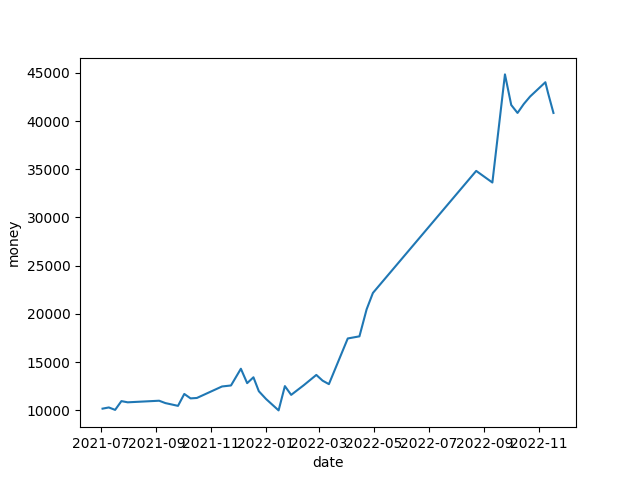

Total trades: 3928
Good trades: 2549 (64.89%)
Min Diff: $-885.00
Max Diff: $613.00
Min Pct. Change: -95.02%
Max Pct. Change: 350.00%


,id,money,price,options,days_to_expire,diff,pct_change
count,7858.0,7858.0,7858.0,7858.0,7858.0,6043.0,6043.0
mean,-1.2959757724139316e+16,21057.417734789313,209.6482565538305,27.635403410537034,41.053112751336215,-4.722323349329803,2.107703290069451
std,5.431752512204155e+18,9805.580180253104,211.07132976034646,18.279672347282098,7.9055493988210745,109.02584964976755,45.46579742324926
min,-9.221033560298644e+18,5161.5999999985015,4.0,0.0,30.04,-885.0,-95.01779359430604
25%,-4.922160824373673e+18,10870.769999999253,40.0,13.0,35.96,-46.0,-29.227680201192555
50%,-1.0542828786951312e+16,20065.1399999968,133.0,24.0,39.0,-5.0,-12.676056338028175
75%,4.808785071998562e+18,29310.83999999457,327.0,38.0,45.04,30.0,26.241134751773043
max,9.212853097018793e+18,44850.5999999948,1371.0,92.0,59.04,613.0,350.0


In [ ]:
df_trades = pd.DataFrame(trade_data)
# df_trades = df_trades.loc[df_trades["type"] == "call"]

df_trades["diff"] = df_trades.groupby("id")["price"].diff()
df_trades["pct_change"] = df_trades.groupby("id")["price"].pct_change() * 100

field_to_plot = "money"
# df_trades_plot = df_trades_plot.copy()
# df_trades_plot = df_trades.loc[(df_trades["side"] == "sell")]
df_trades_plot = df_trades.loc[(df_trades["side"] == "sell") & (df_trades["options"] == 0)]

# field_to_plot = "options"
# df_trades_plot = df_trades.groupby(["date"]).max("options").reset_index()

fig = figure(figsize=(13, 4), dpi=80)

plt.close(fig)
plt.clf()
plt.plot(pd.to_datetime(df_trades_plot["date"]), df_trades_plot[field_to_plot])
plt.xlabel("date")
plt.ylabel(field_to_plot)
plt.show()

total_trades = len(df_trades.loc[df_trades["side"] == "sell"])
good_trades = (df_trades.dropna()["diff"] > 0).sum()
print(f"Total trades: {total_trades}")
print(f"Good trades: {good_trades} ({good_trades/total_trades*100:.2f}%)")
print(f"Min Diff: ${df_trades['diff'].min():.2f}")
print(f"Max Diff: ${df_trades['diff'].max():.2f}")
print(f"Min Pct. Change: {df_trades['pct_change'].min():.2f}%")
print(f"Max Pct. Change: {df_trades['pct_change'].max():.2f}%")
df_trades.describe().astype(str)